In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg

In [2]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
    sqrtoutputsize = int(np.sqrt(outputsize))
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def NonlinearPoisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    h = 1/(sqrtinputsize-1)
    KX = np.zeros([inputsize,inputsize+1])
    KY = np.zeros([inputsize+1,inputsize])
    for i in range(sqrtinputsize):
        for j in range(sqrtinputsize+1):
            KX[i][j] = a(j*h-0.5*h,i*h)
    for i in range(sqrtinputsize+1):
        for j in range(sqrtinputsize):
            KY[i][j] = a(j*h,i*h-0.5*h)
    OUTPUT = (gallery.nonlinearPoisson((sqrtinputsize,sqrtinputsize),KX,KY)).to_full()
    return OUTPUT

In [3]:
def Multigrid_circle(inputsize, A_A, B, R_A, s, w, NUM_EPOCH):
    A = np.matrix(A_A)
    P = 4*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    for i in range(NUM_EPOCH):
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

In [4]:
def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def rhoAuto(INPUT):
    R = INPUT[0]
    w = INPUT[1]
    P = 4*np.transpose(R)
    M = (w**(-1)) * np.diag(np.diag(A1))
    K = M - A1
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A1),P))),R),A1)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

In [5]:
def optimizer_GD(inputsize, A, R, w, s, learning_rate):
    rhoold = rho(inputsize,A,4*np.transpose(R),R,w,s)
    INPUT = [R,w]
    rhoGra = grad(rhoAuto)
    delta = rhoGra(INPUT)
    R -= learning_rate*delta[0]
    w -= learning_rate*delta[1]
    rhonew = rho(inputsize,A,4*np.transpose(R),R,w,s)
    return R, w, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            P = 4*np.transpose(R)
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhonew <= rhoold and i<100:
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        Radius.append(Rnew)
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

In [6]:
finegridsize = 5
s = 1
w = 2/3
MAX_ITER = 50

In [7]:
e = 0.01
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)

In [8]:
inputsize = (2**finegridsize-1)**2
inputsize = int(inputsize)
sqrtinputsize = int(np.sqrt(inputsize))
outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
sqrtoutputsize = int(np.sqrt(outputsize))
h = 1/(sqrtinputsize-1)
A0 = Poisson(inputsize)
A1 = NonlinearPoisson(inputsize)
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
R = Restriction(inputsize)
P = 4*np.transpose(R)

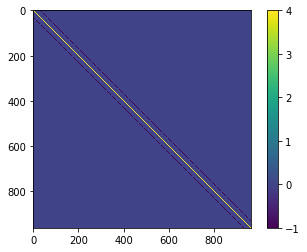

In [9]:
plt.imshow(A0)
plt.colorbar()

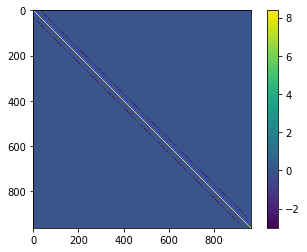

In [10]:
plt.imshow(A1)
plt.colorbar()

In [11]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1, RightF, R, s, w, MAX_ITER)

Residual = 11.25248519787601
Interation = 0
Residual = 1.9617626890783948
Interation = 1
Residual = 0.481898145299486
Interation = 2
Residual = 0.1370462020012952
Interation = 3
Residual = 0.04380519438321566
Interation = 4
Residual = 0.015272302950418357
Interation = 5
Residual = 0.005665748378214013
Interation = 6
Residual = 0.0021996236648069824
Interation = 7
Residual = 0.0008839252599224659
Interation = 8
Residual = 0.000364814909429661
Interation = 9
Residual = 0.0001537252708300438
Interation = 10
Residual = 6.583186484620383e-05
Interation = 11
Residual = 2.854994964041852e-05
Interation = 12
Residual = 1.2504891295738845e-05
Interation = 13
Residual = 5.52044044180712e-06
Interation = 14
Residual = 2.4525545425385153e-06
Interation = 15
Residual = 1.0952405164846256e-06
Interation = 16
Residual = 4.912035445703087e-07
Interation = 17
Residual = 2.2109503542570839e-07
Interation = 18
Residual = 9.98233938173324e-08
Interation = 19
Residual = 4.5189858547908686e-08
Interation = 

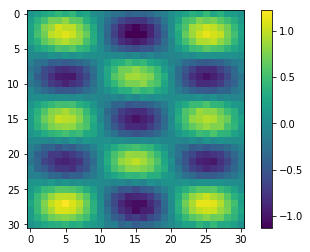

In [12]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Text(0, 0.5, 'Residual of GMM')

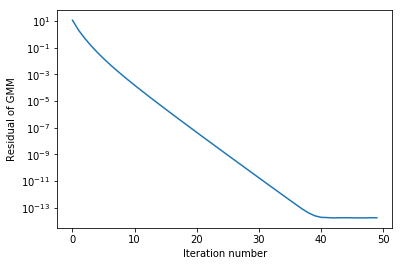

In [13]:
plt.semilogy(GMM_Res)
plt.xlabel('Iteration number')
plt.ylabel('Residual of GMM')

In [14]:
GMM_Radius = rho(inputsize,A1,4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.48948093396927367


In [17]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1, Restriction(inputsize),  2/3, s, learning_rate = 1e-1,accept_radius = GMM_Radius,step_length = 1e-1)

======Section 1======
L = 0.2
rho = 0.4129292618384779
Decrease the step_length, learning_rate and Restart!!
step_length = 0.010000000000000002
learning_rate = 0.010000000000000002
rhonew = 0.9918392528690576
L = 0.020000000000000004
rho = 0.44943667260365955
L = 0.030000000000000006
rho = 0.44482220118545973
L = 0.04000000000000001
rho = 0.4403345045068951
L = 0.05000000000000001
rho = 0.4358554565203105
L = 0.06000000000000001
rho = 0.4316260228101481
L = 0.07
rho = 0.42792181127340434
L = 0.08000000000000002
rho = 0.4379814728185527
Decrease the step_length, learning_rate and Restart!!
step_length = 0.0010000000000000002
learning_rate = 0.0010000000000000002
rhonew = 0.6991754363740439
L = 0.0020000000000000005
rho = 0.4536128253085435
L = 0.003000000000000001
rho = 0.4531451484884259
L = 0.004000000000000001
rho = 0.4526782902356031
L = 0.005000000000000001
rho = 0.4522121610307894
L = 0.006000000000000001
rho = 0.45174671574018294
L = 0.007000000000000001
rho = 0.4512819339460963


L = 0.10700000000000008
rho = 0.4080871300083167
L = 0.10800000000000008
rho = 0.4076863394132291
L = 0.10900000000000008
rho = 0.40728615762709347
L = 0.11000000000000008
rho = 0.4068865897535173
L = 0.11100000000000008
rho = 0.40648764204694204
L = 0.11200000000000009
rho = 0.4060893221132684
L = 0.11300000000000009
rho = 0.40569163913692474
L = 0.11400000000000009
rho = 0.40529460413373003
L = 0.11500000000000009
rho = 0.4048982302265709
L = 0.11600000000000009
rho = 0.4045025329375038
L = 0.11700000000000009
rho = 0.4041075304851784
L = 0.11800000000000009
rho = 0.403713244070286
L = 0.11900000000000009
rho = 0.40331969812408036
L = 0.12000000000000009
rho = 0.4029269204862484
L = 0.1210000000000001
rho = 0.40253494246942456
L = 0.1220000000000001
rho = 0.4021437987601144
L = 0.1230000000000001
rho = 0.4017535271022985
L = 0.1240000000000001
rho = 0.4013641677139462
L = 0.12500000000000008
rho = 0.4009757624018146
L = 0.12600000000000008
rho = 0.4005883533691595
L = 0.1270000000000

L = 0.22600000000000017
rho = 0.37504200264196214
L = 0.22700000000000017
rho = 0.3749655269828464
L = 0.22800000000000017
rho = 0.37489149510533915
L = 0.22900000000000018
rho = 0.3748198952812635
L = 0.23000000000000018
rho = 0.3747507181406135
L = 0.23100000000000018
rho = 0.3746839567052202
L = 0.23200000000000018
rho = 0.3746196064297619
L = 0.23300000000000018
rho = 0.37455766524516687
L = 0.23400000000000018
rho = 0.3744981336002703
L = 0.23500000000000018
rho = 0.3744410144983916
L = 0.23600000000000018
rho = 0.3743863135262636
L = 0.23700000000000018
rho = 0.374334038873409
L = 0.23800000000000018
rho = 0.3742842013406346
L = 0.23900000000000018
rho = 0.3742368143367728
L = 0.24000000000000019
rho = 0.37419189386315266
L = 0.2410000000000002
rho = 0.37414945848554554
L = 0.2420000000000002
rho = 0.37410952929350555
L = 0.2430000000000002
rho = 0.37407212984713956
L = 0.2440000000000002
rho = 0.3740372861114018
L = 0.2450000000000002
rho = 0.37400502637803196
L = 0.246000000000

L = 0.34600000000000025
rho = 0.38462593086337515
L = 0.34700000000000025
rho = 0.3847866172688141
L = 0.34800000000000025
rho = 0.3849466133782014
L = 0.34900000000000025
rho = 0.38510589848752064
L = 0.35000000000000026
rho = 0.38526445241268414
L = 0.35100000000000026
rho = 0.38542225543088565
L = 0.35200000000000026
rho = 0.38557928822613097
L = 0.35300000000000026
rho = 0.3857355318389304
L = 0.35400000000000026
rho = 0.38589096762008945
L = 0.35500000000000026
rho = 0.3860455771885432
L = 0.35600000000000026
rho = 0.38619934239314474
L = 0.35700000000000026
rho = 0.38635224527830514
L = 0.35800000000000026
rho = 0.386504268053372
L = 0.35900000000000026
rho = 0.38665539306562735
L = 0.36000000000000026
rho = 0.38680560277676596
L = 0.36100000000000027
rho = 0.3869548797427285
L = 0.36200000000000027
rho = 0.3871032065967392
L = 0.36300000000000027
rho = 0.38725056603541347
L = 0.36400000000000027
rho = 0.3873969408077815
L = 0.36500000000000027
rho = 0.38754231370709946
L = 0.366

L = 0.46500000000000036
rho = 0.3953212039093879
L = 0.46600000000000036
rho = 0.39533578244274314
L = 0.46700000000000036
rho = 0.3953495473725246
L = 0.46800000000000036
rho = 0.3953625135546081
L = 0.46900000000000036
rho = 0.39537469559914323
L = 0.47000000000000036
rho = 0.3953861078668419
L = 0.47100000000000036
rho = 0.3953967644660537
L = 0.47200000000000036
rho = 0.3954066792505723
L = 0.47300000000000036
rho = 0.3954158658181544
L = 0.47400000000000037
rho = 0.3954243375097025
L = 0.47500000000000037
rho = 0.39543210740908064
L = 0.47600000000000037
rho = 0.39543918834351904
L = 0.47700000000000037
rho = 0.3954455928845734
L = 0.47800000000000037
rho = 0.3954513333496032
L = 0.47900000000000037
rho = 0.39545642180372215
L = 0.48000000000000037
rho = 0.39546087006219494
L = 0.48100000000000037
rho = 0.3954646896932373
L = 0.4820000000000004
rho = 0.39546789202118254
L = 0.4830000000000004
rho = 0.39547048812998514
L = 0.4840000000000004
rho = 0.3954724888670245
L = 0.485000000

L = 0.5850000000000004
rho = 0.39385350915680795
L = 0.5860000000000004
rho = 0.39382805074480703
L = 0.5870000000000004
rho = 0.3938025349192797
L = 0.5880000000000004
rho = 0.3937769646276707
L = 0.5890000000000004
rho = 0.3937513427952637
L = 0.5900000000000004
rho = 0.39372567232537053
L = 0.5910000000000004
rho = 0.3936999560995307
L = 0.5920000000000004
rho = 0.393674196977695
L = 0.5930000000000004
rho = 0.3936483977984254
L = 0.5940000000000004
rho = 0.39362256137907814
L = 0.5950000000000004
rho = 0.3935966905159965
L = 0.5960000000000004
rho = 0.39357078798469974
L = 0.5970000000000004
rho = 0.3935448565400719
L = 0.5980000000000004
rho = 0.3935188989165488
L = 0.5990000000000004
rho = 0.39349291782830603
L = 0.6000000000000004
rho = 0.39346691596944516
L = 0.6010000000000004
rho = 0.39344089601418136
L = 0.6020000000000004
rho = 0.39341486061702774
L = 0.6030000000000004
rho = 0.3933888124129829
L = 0.6040000000000004
rho = 0.3933627540177142
L = 0.6050000000000004
rho = 0.3

L = 0.7050000000000005
rho = 0.391067751289045
L = 0.7060000000000005
rho = 0.3910516137866727
L = 0.7070000000000005
rho = 0.39103565864237233
L = 0.7080000000000005
rho = 0.3910198871107866
L = 0.7090000000000005
rho = 0.3910043004344539
L = 0.7100000000000005
rho = 0.39098889984355495
L = 0.7110000000000005
rho = 0.39097368655602777
L = 0.7120000000000005
rho = 0.3909586617772372
L = 0.7130000000000005
rho = 0.39094382670017114
L = 0.7140000000000005
rho = 0.39092918250501124
L = 0.7150000000000005
rho = 0.3909147303594433
L = 0.7160000000000005
rho = 0.39090047141807344
L = 0.7170000000000005
rho = 0.39088640682292786
L = 0.7180000000000005
rho = 0.39087253770263597
L = 0.7190000000000005
rho = 0.390858865173204
L = 0.7200000000000005
rho = 0.3908453903368579
L = 0.7210000000000005
rho = 0.3908321142832334
L = 0.7220000000000005
rho = 0.3908190380877018
L = 0.7230000000000005
rho = 0.39080616281319464
L = 0.7240000000000005
rho = 0.3907934895077414
L = 0.7250000000000005
rho = 0.39

L = 0.8250000000000006
rho = 0.40418777159164937
L = 0.8260000000000006
rho = 0.40382394353046247
L = 0.8270000000000006
rho = 0.4034770548212358
L = 0.8280000000000006
rho = 0.4031391222364244
L = 0.8290000000000006
rho = 0.4028066855802462
L = 0.8300000000000006
rho = 0.4024779911611155
L = 0.8310000000000006
rho = 0.4021520596524058
L = 0.8320000000000006
rho = 0.4018283085145187
L = 0.8330000000000006
rho = 0.4015063773521805
L = 0.8340000000000006
rho = 0.40118603875424164
L = 0.8350000000000006
rho = 0.40086714916755084
L = 0.8360000000000006
rho = 0.40054962013419604
L = 0.8370000000000006
rho = 0.4002334006087927
L = 0.8380000000000006
rho = 0.3999184656526669
L = 0.8390000000000006
rho = 0.39960480897383194
L = 0.8400000000000006
rho = 0.3992924378763518
L = 0.8410000000000006
rho = 0.3989813697642769
L = 0.8420000000000006
rho = 0.39867162966916064
L = 0.8430000000000006
rho = 0.3983632484582685
L = 0.8440000000000006
rho = 0.39805626149411366
L = 0.8450000000000006
rho = 0.3

L = 0.9450000000000007
rho = 0.3933473063320756
L = 0.9460000000000007
rho = 0.3933798676800964
L = 0.9470000000000007
rho = 0.39341156472324107
L = 0.9480000000000007
rho = 0.39344452778601335
L = 0.9490000000000007
rho = 0.3934762758554778
L = 0.9500000000000007
rho = 0.39350969774003164
L = 0.9510000000000007
rho = 0.39354142547810866
L = 0.9520000000000007
rho = 0.39357538606848275
L = 0.9530000000000007
rho = 0.3936069965065983
L = 0.9540000000000007
rho = 0.39364160745987725
L = 0.9550000000000007
rho = 0.3936729686140379
L = 0.9560000000000007
rho = 0.39370838614982706
L = 0.9570000000000007
rho = 0.3937393185153297
L = 0.9580000000000007
rho = 0.39377576183458124
L = 0.9590000000000007
rho = 0.39380602222651406
L = 0.9600000000000007
rho = 0.3938438005486438
L = 0.9610000000000007
rho = 0.3938730623075525
L = 0.9620000000000007
rho = 0.39391261566005475
L = 0.9630000000000007
rho = 0.3939404470034438
L = 0.9640000000000007
rho = 0.39398241009206675
L = 0.9650000000000007
rho = 

In [18]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1, RightF, Rnew, s, wnew, MAX_ITER)

Residual = 15.315986107988147
Interation = 0
Residual = 4.8735561804731535
Interation = 1
Residual = 1.625483281866536
Interation = 2
Residual = 0.5551184492710135
Interation = 3
Residual = 0.19254182079435136
Interation = 4
Residual = 0.06743340891347181
Interation = 5
Residual = 0.023763938242722042
Interation = 6
Residual = 0.008409522759821488
Interation = 7
Residual = 0.00298476608068847
Interation = 8
Residual = 0.0010617295283567242
Interation = 9
Residual = 0.00037833547105302194
Interation = 10
Residual = 0.00013500940952986405
Interation = 11
Residual = 4.823719175551344e-05
Interation = 12
Residual = 1.7253046344936233e-05
Interation = 13
Residual = 6.176870346712542e-06
Interation = 14
Residual = 2.213378939891018e-06
Interation = 15
Residual = 7.937835728852897e-07
Interation = 16
Residual = 2.848972334499786e-07
Interation = 17
Residual = 1.0232917577124491e-07
Interation = 18
Residual = 3.678108895105524e-08
Interation = 19
Residual = 1.3229846774107681e-08
Interation = 

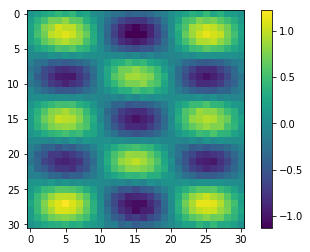

In [19]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Text(0, 0.5, 'Residual of Global DMM')

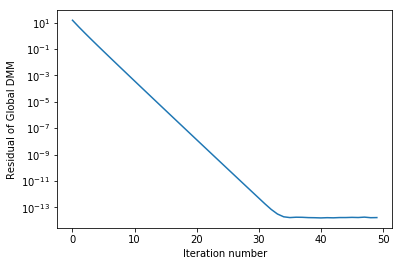

In [20]:
plt.semilogy(DMM_Res)
plt.xlabel('Iteration number')
plt.ylabel('Residual of Global DMM')

In [21]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.39542928951974865


R under log10(abs())


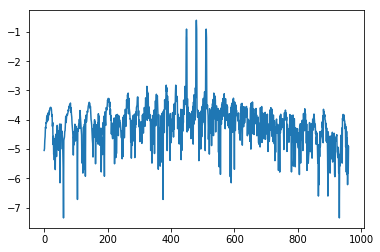

In [22]:
print("R under log10(abs())")
plt.plot(np.log10(np.abs(Rnew))[round(0.5*outputsize)][:])

In [23]:
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A = gallery.nonlinearPoisson((n,n), kx, ky)

In [24]:
PR_stencil_type = "m9p"
gmm = dgmg.DeepMG(A, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
num_iter = 2500
step_size = 1e-4
opt_par = gmm.optimize(num_iter=num_iter, step_size=step_size)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/2500
Upper bound estimation = 0.25746863235739004
Iteration 200/2500
Upper bound estimation = 0.24441878821975532
Iteration 300/2500
Upper bound estimation = 0.23361130314062314
Iteration 400/2500
Upper bound estimation = 0.22495209125179244
Iteration 500/2500
Upper bound estimation = 0.2131654497558283
Iteration 600/2500
Upper bound estimation = 0.19846523001570412
Iteration 700/2500
Upper bound estimation = 0.18910856651254127
Iteration 800/2500
Upper bound estimation = 0.18107328218565144
Iteration 900/2500
Upper bound estimation = 0.17613194175580602
Iteration 1000/2500
Upper bound estimation = 0.1709747244809831
Iteration 1100/2500
Upper bound estimation = 0.1646395983014273
Iteration 1200/2500
Upper bound estimation = 0.1629809048288046
Iteration 1300/2500
Upper bound estimation = 0.15908316503529532
Iteration 1400/2500
Upper bound estimation = 0.15724207083245398
Iteration 1500/2500
Upper bound estimation = 0.15621524581084117
Iteration 1600/2500
Upper bound estima

In [25]:
print(gmm)
convergence = gmm.get_optimizer_convergence()
conv_time = gmm.get_optimization_time()
gmm.update_prd(opt_par)
DMM_rho = gmm.compute_rho()
print("DMM rho = {}".format(DMM_rho))

Dimension of matrix A for levels:
Level = 0, dimension = (15, 15)
Level = 1, dimension = (31, 31)

DMM rho = 0.13077094016371182


[1.11877681e+01 1.65849816e+00 2.06862106e-01 1.92614252e-02
 1.92977209e-03 1.84829653e-04 2.19641980e-05 2.54833883e-06
 2.97738798e-07 3.56838699e-08 4.23385706e-09 5.12133977e-10
 6.21956588e-11 7.62079568e-12 9.47366658e-13 1.20347942e-13
 1.99438668e-14 1.07680837e-14 1.08802030e-14 1.08211220e-14
 9.69399910e-15 1.08238036e-14 1.03292547e-14 1.17431277e-14
 1.17562295e-14 1.11189062e-14 1.12135956e-14 1.04921427e-14
 1.07012456e-14 1.09311899e-14 9.86187355e-15 1.05946564e-14
 1.02558857e-14 1.11249456e-14 1.11517704e-14 1.12004518e-14
 1.21999004e-14 1.08781317e-14 1.26922040e-14 1.11874439e-14
 1.17569341e-14 1.07295058e-14 1.18902972e-14 1.07154298e-14
 1.09299649e-14 1.05895991e-14 1.00717882e-14 1.07232673e-14
 1.09499322e-14 1.14502304e-14]


Text(0, 0.5, 'Residual of local DMM')

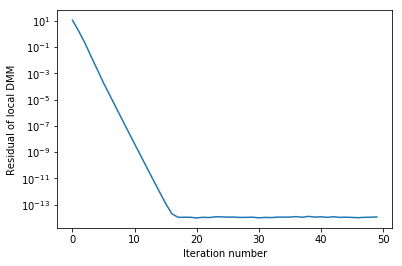

In [29]:
x = gmm.solve(RightF, np.random.randn(A.shape), tol=0, max_iter=50)
print(gmm.get_gmg_convergence())
plt.semilogy(gmm.get_gmg_convergence())
plt.xlabel('Iteration number')
plt.ylabel('Residual of local DMM')

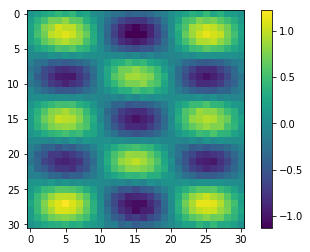

In [30]:
x = x.reshape(A.dim)
plt.imshow(x)
plt.colorbar()

In [31]:
np.set_printoptions(threshold=np.inf)
print("omega = {}".format(opt_par[2]))

omega = 0.8001714526530804


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)


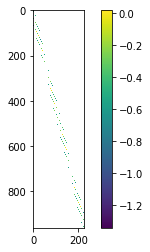

In [32]:
P = opt_par[0][0]
k = int(2**(np.log2(n+1)-1)-1) 
P_Matrix = np.zeros([n**2,k**2])
for i in range(k):
    for j in range(k):
        C = P[i][j]
        for l in range(3):
            for m in range(3):
                P_Matrix[n*(2*i+l)+(2*j+m)][k*i+j] = C[l][m]
plt.imshow(np.log10(np.abs(P_Matrix)))
plt.colorbar()

P under log10(abs())


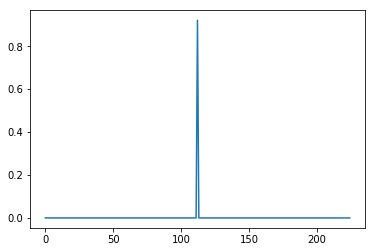

In [33]:
print("P under log10(abs())")
plt.plot(P_Matrix[round(0.5*inputsize)][:])

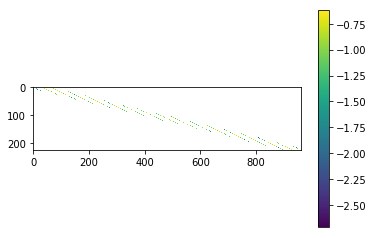

In [34]:
R = opt_par[1][0]
R_Matrix = np.zeros([k**2,n**2])
for i in range(k):
    for j in range(k):
        C = R[i][j]
        for l in range(3):
            for m in range(3):
                R_Matrix[k*i+j][n*(2*i+l)+(2*j+m)] = C[l][m]
plt.imshow(np.log10(np.abs(R_Matrix)))
plt.colorbar()

R under log10(abs())


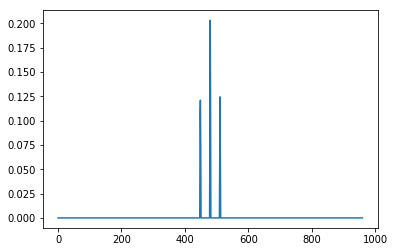

In [35]:
print("R under log10(abs())")
plt.plot(R_Matrix[:][round(0.5*outputsize)])

Text(0, 0.5, 'Residual')

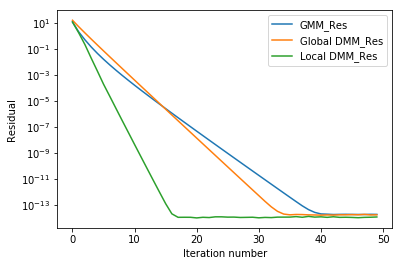

In [36]:
plt.semilogy(GMM_Res, label = 'GMM_Res')
plt.semilogy(DMM_Res, label = 'Global DMM_Res')
plt.semilogy(gmm.get_gmg_convergence(), label = 'Local DMM_Res')
plt.legend(loc='upper right')
plt.xlabel('Iteration number')
plt.ylabel('Residual')